In [1]:
import sys
import os
import itertools

base_path = os.path.dirname(os.path.dirname(os.path.abspath(".")))
sys.path.append(base_path)

import torch.optim as optim
import numpy as np
from tqdm import tqdm
import logging


from utils.config import img_param_init, set_random_seed
from utils.dataload import DomainDataset, get_data
from model.clip import ClipModelMA, Adapter, Client
from process import train_client, communicate, test_server, test_client, fetch
class argparser():
   dataset = 'officehome'
   root_dir='/mnt/sda/zd/data/splitdata_new/'
   net='ViT-B/16'
   seed=0
   logdir=None
   device="cuda:0"
   n_clients=10
   n_experts=5
   inner_iter=10
   n_task=10
   # data setting parameter
   datapercent=8e-1
   batch=100
   # optimizer parameter
   lr=2e-3
   beta1=0.9
   beta2=0.98
   eps=1e-6
   weight_decay=0.2
import logging
def init():
    args = argparser()
    if args.logdir is not None:
        logging.basicConfig(filename=args.logdir, level=logging.DEBUG)
    else:
        logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
    args.random_state = np.random.RandomState(1)
    set_random_seed(args.seed)
    args = img_param_init(args)  # init the dataset parameters(domains and classnum)
    args.thresh = 1e-4
    return args

In [2]:
    
def init():
    args = argparser()
    if args.logdir is not None:
        logging.basicConfig(filename=args.logdir, level=logging.DEBUG)
    else:
        logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
    args.random_state = np.random.RandomState(1)
    set_random_seed(args.seed)
    args = img_param_init(args)  # init the dataset parameters(domains and classnum)
    args.thresh = 1e-4
    return args

In [3]:
def freeze_param(model):
    for name, param in model.named_parameters():
        param.requires_grad = False
args = init()

args.dataset = "officehome"
args.root_dir = "/mnt/sda/zd/data/OF10-10-1000-2023/"

logging.info("Argument init successful!")
server_model: ClipModelMA = ClipModelMA(args.net, n_experts=args.n_experts, device=args.device)  # load the server data
dataloader: DomainDataset = get_data(args.dataset)(args, server_model.preprocess)
train_loaders, test_loaders, labels = dataloader.get_dataloader(0)
assert len(train_loaders) == args.n_clients, "This just mention you to make sure the n_clients \
                                            equals to the datasplit client number."
server_model.labels = labels
server_model.init_prompt()
server_model.init_MoE()
freeze_param(server_model.model)
logging.info("Data init successful!")



Argument init successful!
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client0/task0/Clipart
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client1/task0/Product
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client2/task0/Real World
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client3/task0/Art
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client4/task0/Clipart
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client5/task0/Product
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client6/task0/Real World
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client7/task0/Art
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client8/task0/Clipart
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/client9/task0/Product
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/test/Clipart with ['Clipart', 'Product', 'Real World', 'Art']
loading data in /mnt/sda/zd/data/OF10-10-1000-2023/test/Product with ['Clipart', 'Product', 'Real World', 'Art']
loading data in /mnt

In [4]:
import torch
server_model.MoE.gating.load_state_dict(torch.load("save/gating9.pkl"))
server_model.MoE.gating.to(args.device)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=5, bias=True)
)

In [33]:
# from torch.utils.data import TensorDataset, DataLoader
clients_data = [Client("ViT-B/16", args.device) for _ in range(10)]
with torch.no_grad():
    all_feature = []
    for idx, client_loader in tqdm(enumerate(train_loaders)):
        temp_hook = server_model.model.visual.transformer.resblocks[5].register_forward_hook(clients_data[idx].extract_feature())
        for image,_,_ in client_loader:
            server_model.model.encode_image(image.to(args.device))
        temp_hook.remove()

        single_feature = []
        temp_data = torch.tensor(clients_data[idx].preprocess(), dtype=torch.float)
        temp_array = np.array([0 for i in range(args.n_experts)], dtype=np.float64)
        for i, data in enumerate(temp_data):
            res = server_model.MoE.gating(data.to(args.device))
            # print(np.array(res.cpu()))
            temp_array += np.array(res.cpu(), dtype=np.float64)
            if (i%20) == 0:
                single_feature.append(temp_array/25)
                temp_array = np.array([0 for i in range(args.n_experts)],dtype=np.float64)
        all_feature.append(np.stack(single_feature))
all_feature = np.vstack(all_feature)
all_feature.shape    



0it [00:00, ?it/s]

10it [01:15,  7.53s/it]


执行t-SNE降维
可视化数据并使用标签着色


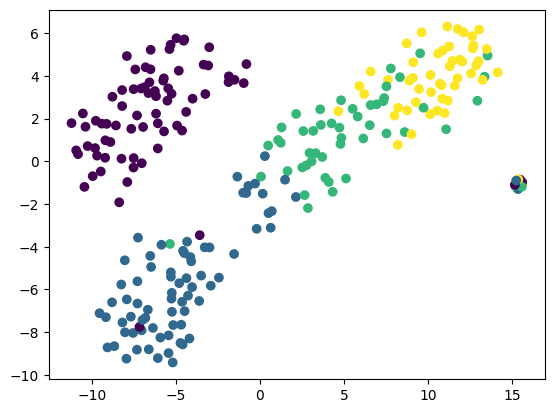

In [40]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import itertools

label = [0,1,2,3,0,1,2,3,0,1]
labels = itertools.chain.from_iterable([[i]*25 for i in label ])

print("执行t-SNE降维")
tsne = TSNE(n_components=2, perplexity=40, learning_rate=100, random_state=42, method="exact")
tsne_result = tsne.fit_transform(all_feature)

print("可视化数据并使用标签着色")
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=list(labels))  # 使用'viridis'颜色地图
# plt.title("t-SNE Visualization with Labels")
# plt.colorbar()
plt.show()

# DoaminNet

In [ ]:
import sys
import os
import itertools

base_path = os.path.dirname(os.path.dirname(os.path.abspath(".")))
sys.path.append(base_path)

import torch.optim as optim
import numpy as np
from tqdm import tqdm
import logging


from utils.config import img_param_init, set_random_seed
from utils.dataload import DomainDataset, get_data
from model.clip import ClipModelMA, Adapter, Client
from process import train_client, communicate, test_server, test_client, fetch
class argparser():
   dataset = 'officehome'
   root_dir='/mnt/sda/zd/data/splitdata_new/'
   net='ViT-B/16'
   seed=0
   logdir=None
   device="cuda:0"
   n_clients=10
   n_experts=5
   inner_iter=10
   n_task=10
   # data setting parameter
   datapercent=8e-1
   batch=100
   # optimizer parameter
   lr=2e-3
   beta1=0.9
   beta2=0.98
   eps=1e-6
   weight_decay=0.2
import logging
def init():
    args = argparser()
    if args.logdir is not None:
        logging.basicConfig(filename=args.logdir, level=logging.DEBUG)
    else:
        logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
    args.random_state = np.random.RandomState(1)
    set_random_seed(args.seed)
    args = img_param_init(args)  # init the dataset parameters(domains and classnum)
    args.thresh = 1e-4
    return args